<a href="https://colab.research.google.com/github/alexmrin/Kaggle/blob/main/digit_rec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [178]:
!mkdir ~p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c digit-recognizer
#!unzip digit-recognizer

mkdir: cannot create directory ‘~p’: File exists
mkdir: cannot create directory ‘/root/.kaggle’: File exists
digit-recognizer.zip: Skipping, found more recently modified local copy (use --force to force download)


In [179]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from torchvision import transforms
import torch.nn.functional as F
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [180]:
training_data = pd.read_csv('/content/train.csv')
training_data

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Data Preprocessing

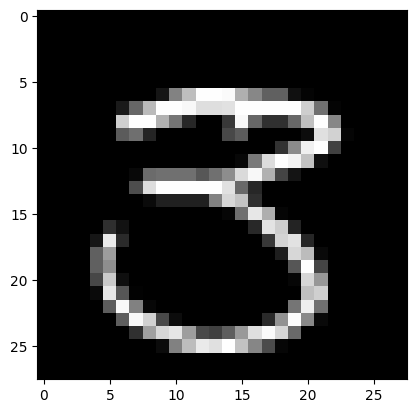

In [181]:
training_data.index = range(1, training_data.shape[0]+1)
X_train = training_data.drop(columns=['label'])
y_train = training_data['label']
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

sample_image = X_train[7].reshape(28, 28)
plt.imshow(sample_image, cmap='gray')

In [182]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Making Dataset class

In [183]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

class mnist_Dataset(Dataset):
  def __init__(self, X, y=None, transform=transform):
    self.features = X.astype(np.float32) / 255.0
    self.labels = y
    self.transform = transform

  def __len__(self):
    return self.features.shape[0]

  def __getitem__(self, idx):
    image = self.features[idx]
    image = image.reshape(28, 28)
    image = np.expand_dims(image, axis=-1)
    if self.labels is None:
      return self.transform(image)
    else:
      return (self.transform(image), self.labels[idx])

train_dataset = mnist_Dataset(X_train, y=y_train)
val_dataset = mnist_Dataset(X_val, y=y_val)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)


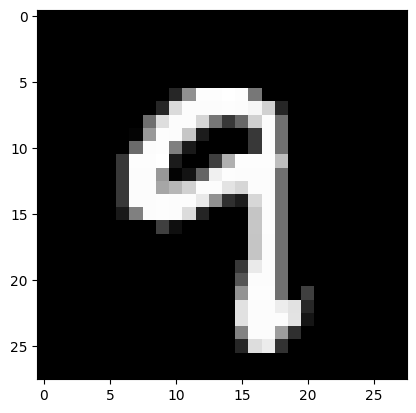

In [184]:
test_image, test_label = train_dataset[14]
plt.imshow(test_image[0], cmap='gray')

### **Model Class**

In [185]:
class mnistNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.features = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0),
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
      nn.Linear(64*5*5, 512),
      nn.ReLU(),
      nn.Dropout(p=0.3),
      nn.Linear(512, 10),
    )


  def forward(self, X):
    features = self.features(X)
    classifier = torch.flatten(features, start_dim = 1)
    output = self.classifier(classifier)
    return output

model = mnistNet()
model.to(device)

mnistNet(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1600, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

100%|██████████| 525/525 [00:05<00:00, 93.82it/s] 


Epoch: 1/2, loss: 0.14768331242459162
Epoch: 1/2, loss: 0.08362835685539087


100%|██████████| 525/525 [00:08<00:00, 60.82it/s]


Epoch: 2/2, loss: 0.07258994577629935
Epoch: 2/2, loss: 0.04726707873597854


<Axes: >

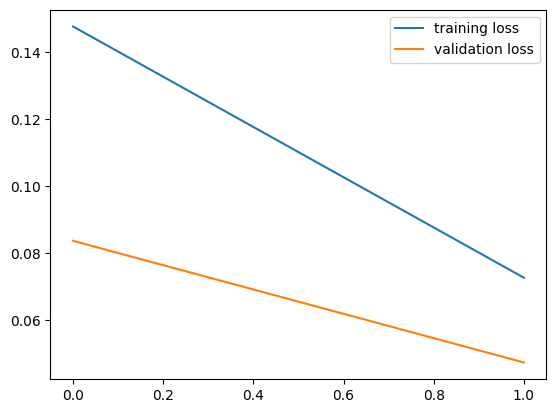

In [186]:
optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay=0.004)
num_epochs = 2
criterion = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  model.train()
  total_loss = 0
  for images, labels in tqdm(train_dataloader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  total_loss /= len(train_dataloader)
  train_losses.append(total_loss)
  print(f'Epoch: {epoch+1}/{num_epochs}, loss: {total_loss}')

  model.eval()
  total_loss = 0
  for images, labels in val_dataloader:
    with torch.no_grad():
      images, labels = images.to(device), labels.to(device)
      outputs = model(images)
      loss = criterion(outputs, labels)
      total_loss += loss.item()

  total_loss /= len(val_dataloader)
  val_losses.append(total_loss)
  print(f'Epoch: {epoch+1}/{num_epochs}, loss: {total_loss}')

sns.lineplot(train_losses, label="training loss")
sns.lineplot(val_losses, label="validation loss")

In [187]:
test_data = pd.read_csv('/content/test.csv')
test_data.shape[0]

28000

In [188]:
test_data = test_data.to_numpy()
test_dataset = mnist_Dataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=1)

In [189]:
predictions = []
for image in tqdm(test_dataloader):
  image = image.to(device)
  pred = torch.argmax(model(image)).item()
  predictions.append(pred)

100%|██████████| 28000/28000 [00:39<00:00, 710.88it/s]


In [190]:
prediction_df = pd.DataFrame(predictions)
prediction_df

,0
0,2
1,0
2,9
3,0
4,3
...,...
27995,9
27996,7
27997,3
27998,9


In [191]:
prediction_df.rename(columns={0 : 'Label'}, inplace=True)
indices = [i for i in range(1, prediction_df.shape[0] + 1)]
prediction_df.index = indices
prediction_df

,Label
1,2
2,0
3,9
4,0
5,3
...,...
27996,9
27997,7
27998,3
27999,9


In [192]:
prediction_df.index.name = 'ImageId'
prediction_df.to_csv('/content/sample_submission.csv')

In [194]:
!kaggle competitions submit -c digit-recognizer -f '/content/sample_submission.csv' -m 'torch cnn'

100% 208k/208k [00:02<00:00, 76.7kB/s]
Successfully submitted to Digit Recognizer